# Training Notebook

# RSNA 2023 Abdominal Trauma Detection with Tensorflow

This notebook walks you through how to train a **Convolutional Neural Network (CNN)** model using Tensorflow and Keras-CV on the RSNA 2023 Abdominal Trauma Detection dataset made available for this competition.

In this notebook you will learn:

* Loading the data using [`tf.data`](https://www.tensorflow.org/guide/data).
* Applying augmentations inside the data pipeline.
* Create the model using KerasCV presets.
* Train the model.
* Visualize the training plots.

## Notebooks

For this competition we have two starter notebook. This notebook (you are reading) trains the model on the dataset, while there lies another notebook that performs inference and submits to the competition.

1. [**Training Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train)
2. [**Inference Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer)

**Note**: [KerasCV guides](https://keras.io/guides/keras_cv/) is the place to go for a deeper understanding of KerasCV individually.

# Setup and Imports


In [1]:
! python --version

Python 3.10.12


In [2]:
! pip install --upgrade pip
! pip install keras-cv
! pip install seaborn
# ! pip install boto3
! pip install keras_cv_attention_models
! pip install --upgrade tensorflow
! pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for keras_cv_attention_models from https://files.pythonhosted.org/packages/cc/c2/71d0522c1f800e75f43d956d83284b8f1f71ac8b496c275034a295ce4d14/keras_cv_attention_models-1.3.20-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 kB 21.0 MB/s eta 0:00:00
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tensorboard<2

In [3]:
import os
# os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
from keras_cv_attention_models import efficientnet

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Utils
import gc

# plots
from matplotlib import pyplot as plt
import seaborn as sns

# aws
# import boto3


2023-10-15 14:43:44.899505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 14:43:44.899569: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 14:43:44.899621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
tf.__version__

'2.14.0'

# Configuration

A particularly good practise is to have a configuration class for your notebooks. This not only keeps your configurations all at a single place but also becomes handy to map the configs to the performance of the model.

Please play around with the configurations and see how the performance of the model changes.

In [5]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    BATCH_SIZE = 64
    EPOCHS = 25
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE
    REPLICAS = 1
    STRIDE = 10
    MODEL_NAME = 'EfficientNetV1B0'
    DEVICE = 'TPU'

config = Config()

# Reproducibility

We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.

In [6]:
tf.keras.utils.set_random_seed(seed=config.SEED)

# Exploratory Data Analysis (EDA)

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [7]:
BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-v2-dataset"

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [8]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512


In [9]:
# Checking the summary statistics of the dataset
summary_statistics = dataframe.describe()

summary_statistics.iloc[1]

patient_id               34909.677862
bowel_healthy                0.478760
bowel_injury                 0.521240
extravasation_healthy        0.303350
extravasation_injury         0.696650
kidney_healthy               0.870729
kidney_low                   0.076316
kidney_high                  0.052955
liver_healthy                0.812703
liver_low                    0.159864
liver_high                   0.027434
spleen_healthy               0.679192
spleen_low                   0.150220
spleen_high                  0.170588
any_injury                   1.000000
series_id                31188.356056
instance_number            311.704132
width                      512.733062
height                     511.981046
Name: mean, dtype: float64

In [10]:
# Checking for missing values
missing_values = dataframe.isnull().sum()

missing_values

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
series_id                0
instance_number          0
injury_name              0
image_path               0
width                    0
height                   0
dtype: int64

## Class Dependency

We will explore the difference between health columns vs. injury columns

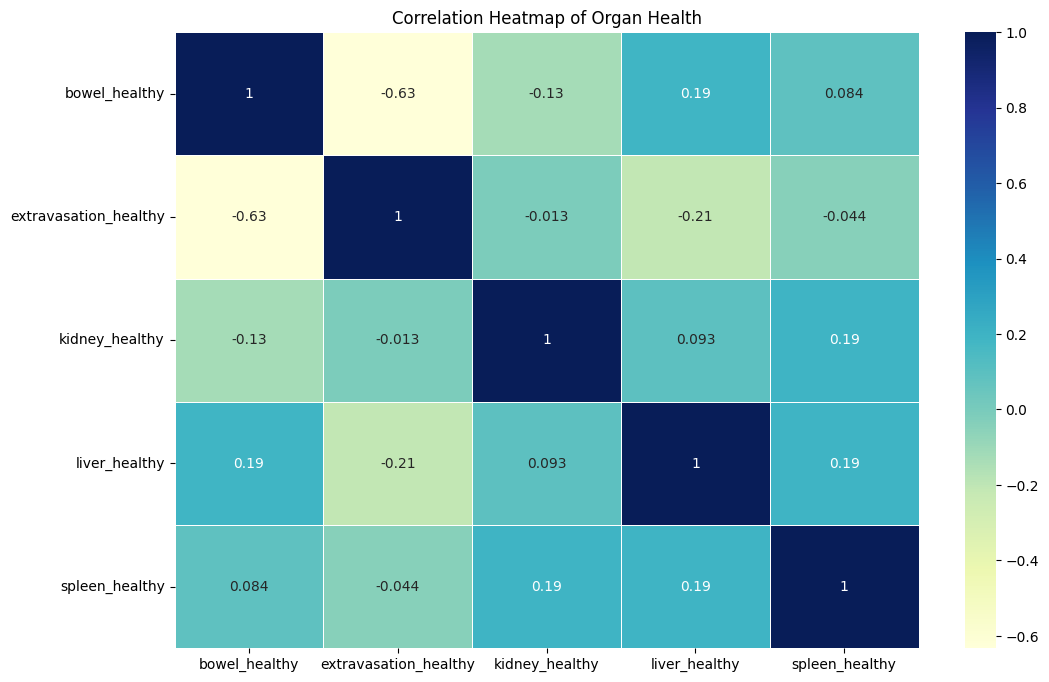

In [11]:
# Selecting columns related to the health of organs
health_columns = [
    "bowel_healthy", "extravasation_healthy", "kidney_healthy", 
    "liver_healthy", "spleen_healthy",
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = dataframe[health_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Health")
plt.show()

The correlations between different health columns are generally small, indicating that the healthy state of one organ might not be strongly related to the healthy state of other organs.

There is no strong correlation between any two specific health-related columns, suggesting that the health status of different organs is relatively independent of each other.

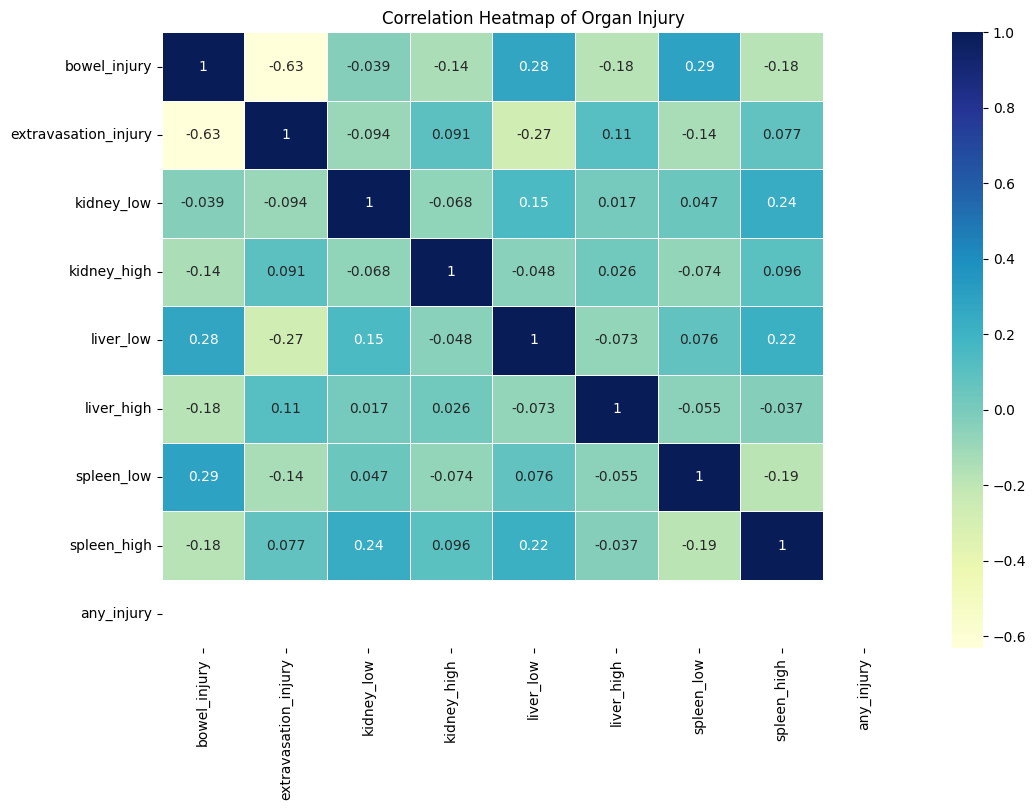

In [12]:
# Selecting columns related to the health of organs
injury_columns = [
    "bowel_injury", "extravasation_injury",
    "kidney_low", "kidney_high", 
    "liver_low", "liver_high",
    "spleen_low", "spleen_high",
    "any_injury"
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = dataframe[injury_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Injury")
plt.show()

### Bowel and Extravasation:

* `bowel_injury`: This shows a moderate correlation with `any_injury` (0.24) and a smaller correlation with `extravasation_injury` (0.13)
* `extravasation_injury`: This has a strong correlation with `any_injury` (0.43) and a moderate correlation with `spleen_high` (0.200).

### Kidney:

* `kidney_low`: This is moderately correlated with `ny_injury` (0.319).
* `kidney_high`: Similar to kidney_low, this is moderately correlated with `any_injury` (0.24).

### Liver:

* `liver_low`: This has a strong correlation with `any_injury` (0.490).
* `liver_high`: This shows a moderate correlation with `any_injury` (0.232).

### Spleen:

* `spleen_low`: This is moderately correlated with `any_injury` (0.425).
* `spleen_high`: This shows a moderate correlation with `any_injury` (0.373) and `extravasation_injury` (0.200).

### Conclusions: 

**The `any_injury` column is moderately to strongly correlated with all other injury columns, suggesting that it may be a summary measure of injury presence across different organs.**

There are some specific correlations between individual injury types, such as the correlation between `extravasation_injury` and `spleen_high`.

The correlations between the low and high levels of organ injuries (e.g., `kidney_low` and `kidney_high`) are generally lower, indicating that these might be independent conditions.

The correlation between different organs' injuries is generally low, which might suggest that injuries to different organs occur independently of each other.

## Note on some observations

1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
2. Complementarity: `bowel_injury` and `bowel_healthy`, as well as `extravasation_injury` and `extravasation_healthy`, are perfectly complementary, with their sum always equal to 1.0.
3. Simplification: For the model, only `{bowel/extravasation}_injury` will be included, and the corresponding healthy status can be calculated using a sigmoid function.
4. Softmax: `{kidney/liver/spleen}_{healthy/low/high}` classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

# Data Wrangling

We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [13]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [14]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

## Data Pipeline /w tf.data

Here we build the data pipeline using `tf.data`. Using `tf.data` we can map out data to an augmentation pipeline simple by using the ` map` API.

Adding augmentations to the data pipeline is as simple as adding a layer into the list of layers that the `Augmenter` processes.

Reference: https://keras.io/api/keras_cv/layers/augmentation/

In [15]:
# Create an augmenter layer with a list of preprocessing layers
augmenter = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), 
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2)
])

def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*config.IMAGE_SIZE, 3])
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    # Create a random seed for stateless operations
    seed = tf.random.uniform(shape=[2], minval=0, maxval=1000, dtype=tf.int32)
    
    # Apply the augmenter layer to the images
    images = augmenter(images)
    
    # Apply some stateless image operations with the random seed
    images = tf.image.stateless_random_brightness(images, max_delta=0.1, seed=seed)
    images = tf.image.stateless_random_contrast(images, lower=0.8, upper=1.2, seed=seed)
    
#     Applying random crop without considering the seed
#     images = tf.image.random_crop(images, size=[tf.shape(images)[0], 32, 32, 3])

    images = tf.image.stateless_random_flip_left_right(images, seed=seed)
    images = tf.image.stateless_random_flip_up_down(images, seed=seed)
    images = tf.image.stateless_random_hue(images, max_delta=0.1, seed=seed)
#     images = tf.image.stateless_random_jpeg_quality(images, min_jpeg_quality=80, max_jpeg_quality=100, seed=seed)
    images = tf.image.stateless_random_saturation(images, lower=0.8, upper=1.2, seed=seed)
    
    # Modifying the application of stateless_random_jpeg_quality using tf.map_fn
    images = tf.map_fn(
        lambda img: tf.image.stateless_random_jpeg_quality(
            img, min_jpeg_quality=80, max_jpeg_quality=100, seed=seed
        ),
        images
    )
    
    # Apply dropout to each image individually
    images = tf.map_fn(dropout, images)

    return (images, labels)


def dropout(image,DIM=config.IMAGE_SIZE, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

#     image = tf.reshape(image,[*DIM,3])
    return image


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [16]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
# images, labels = next(iter(ds))
# images.shape, [label.shape for label in labels]

## Visualise the augmentations

In [17]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    tars = tf.concat(tars,axis=-1).numpy()
    plt.figure(figsize=(size*5, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{tars[img_idx].round(2)}', fontsize=12)
        img = imgs[img_idx,]
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

In [18]:
ds = ds.unbatch().batch(20)
batch = next(iter(ds))

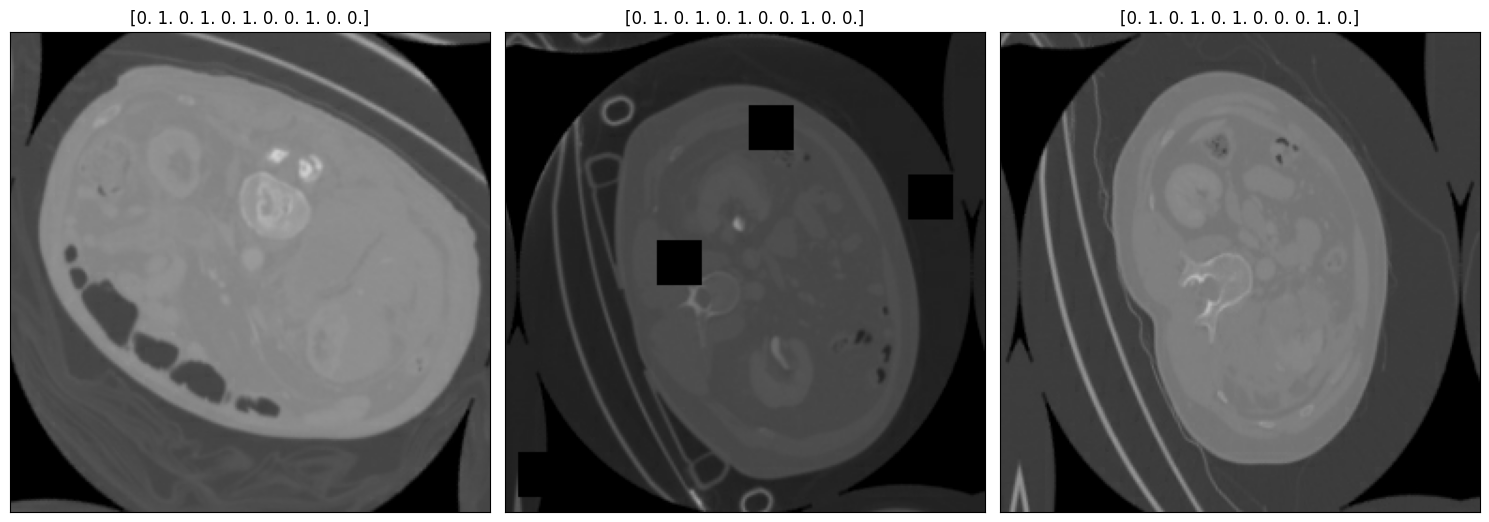

In [19]:
display_batch(batch, 3);

# Modelling

## Build Model

We are going to load a pretrained model from the [list of avaiable backbones in KerasCV](https://keras.io/api/keras_cv/models/backbones/). We are using the `ResNetBackbone` as our backbone. The practise of using a pretrained model and finetuning it to a specific dataset is prevalent in the DL community.

We use the [Functional API](https://keras.io/guides/functional_api/) of Keras to build the model. The design of the model would be such that we input a single image and we get different heads for the various predictions we need (kidney, spleen...).

We have also added a Learning Rate scheduler for you to work with. When an athlete trains, the first step is always to warm up. We take a similar approach to training our models. We warm up with model where the learning rate increses from the initial LR to a higher LR. After the warmup stage we provide a decay algorithm (cosine here). A list of all the learning rate scheduler can be found [here](https://keras.io/api/optimizers/learning_rate_schedules/).

In [20]:
def build_model(warmup_steps, 
                decay_steps, 
                model_name=config.MODEL_NAME,
                dim=config.IMAGE_SIZE, 
                include_top=False):
    
    # Define Input
    inputs = tf.keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
        
    
    # Define backbone
    base = getattr(efficientnet, model_name)(input_shape=(*dim,3),
                                    pretrained='imagenet',
                                    num_classes=0) # get base model (efficientnet), use imgnet weight
    
#     # Define Backbone
#     backbone = keras_cv.models.ResNetV2Backbone.from_preset("resnet50_v2_imagenet")
#     backbone.include_rescaling = False

#     x = backbone(inputs)
    inp = base.inputs
    x = base.output
    
    # GAP to get the activation maps
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Define 'necks' for each head
    x_bowel = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x_bowel = tf.keras.layers.BatchNormalization()(x_bowel)
    
    x_extra = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x_extra = tf.keras.layers.BatchNormalization()(x_extra)
    
    x_liver = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x_liver = tf.keras.layers.BatchNormalization()(x_liver)
    
    x_kidney = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x_kidney = tf.keras.layers.BatchNormalization()(x_kidney)
    
    x_spleen = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x_spleen = tf.keras.layers.BatchNormalization()(x_spleen)
    
    # Add Activation layers
    x_bowel = tf.keras.layers.Activation('silu')(x_bowel)
    x_extra = tf.keras.layers.Activation('silu')(x_extra)
    x_liver = tf.keras.layers.Activation('silu')(x_liver)
    x_kidney = tf.keras.layers.Activation('silu')(x_kidney)
    x_spleen = tf.keras.layers.Activation('silu')(x_spleen)
    
    # Add dropout layers to reduce overfitting
    dropout_rate = 0.3
    x_bowel = tf.keras.layers.Dropout(rate=dropout_rate)(x_bowel)
    x_extra = tf.keras.layers.Dropout(rate=dropout_rate)(x_extra)
    x_liver = tf.keras.layers.Dropout(rate=dropout_rate)(x_liver)
    x_kidney = tf.keras.layers.Dropout(rate=dropout_rate)(x_kidney)
    x_spleen = tf.keras.layers.Dropout(rate=dropout_rate)(x_spleen)

    # Define heads
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    
    # Cosine Decay
    cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.3,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "extra":tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        "liver":tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        "kidney":tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        "spleen":tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    }
    
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    
    print("[INFO] Compiling the model...")
    model.compile(
          optimizer=optimizer,
          loss=loss,
          metrics=metrics
          )
    
    return model

In [21]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=241600
warmup_steps=24160
decay_steps=217440


### Visualising the learning rate scheduler

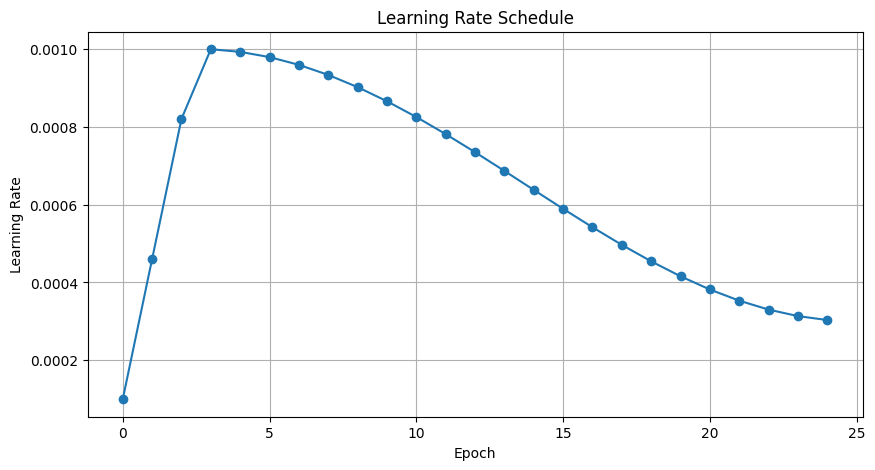

In [22]:
# visualise learning rate scheduler
def visualize_learning_rate(warmup_steps, decay_steps, initial_learning_rate=1e-4, alpha=0.0, epochs=config.EPOCHS):
    """
    Visualize the learning rate over epochs given specific cosine decay parameters.

    Parameters:
        - warmup_steps: int, number of steps for the warmup phase
        - decay_steps: int, number of steps to apply the decay function
        - initial_learning_rate: float, initial learning rate before decay
        - alpha: float, minimum learning rate value as a fraction of the initial_learning_rate
        - warmup_target: float, target warmup learning rate
        - epochs: int, number of epochs to visualize the learning rate for
    """
    cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=alpha,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    lrs = [cosine_decay(epoch*total_train_steps/epochs).numpy() for epoch in range(epochs)]

    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), lrs, marker='o')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# Example usage
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps
visualize_learning_rate(warmup_steps, decay_steps, alpha=0.3, epochs=config.EPOCHS)


We'll use TPU / multi-GPU to speed up the training process, as we're working with tensorflow datasets.

In [23]:
if "TPU" in config.DEVICE:
    tpu = 'local' if config.DEVICE=='TPU-VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        config.DEVICE = "GPU"
        
if config.DEVICE == "GPU"  or config.DEVICE=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        config.DEVICE = "CPU"

if config.DEVICE == "GPU":
    print("Num GPUs Available: ", ngpu)
    
config.AUTOTUNE = tf.data.AUTOTUNE
config.REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {config.REPLICAS}')


connecting to TPU...
Using multi GPU
Num GPUs Available:  2
REPLICAS: 2


In [24]:
config.BATCH_SIZE = config.BATCH_SIZE*config.REPLICAS
print(config.BATCH_SIZE)

128


In [25]:

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * (config.EPOCHS)
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

# Model Creation Inside Strategy Scope: 
with strategy.scope():
    # Your model creation code here, for example:
    model = build_model(warmup_steps, decay_steps)  # Assuming your function from the previous code
    
# Data: Ensure your data is in a TPU-friendly format.
# Example: If you're using tf.data.Dataset for your data, you should batch the data appropriately.

# Define the checkpoint path and filename
checkpoint_filepath = '/kaggle/working'
    
# Create a ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to False to save the entire model
    monitor='val_loss',  # Change to the metric you want to monitor
    mode='min',  # Mode for the 'monitor' metric. 'min' means training will stop when the quantity monitored has stopped decreasing.
    save_best_only=True,  # Only save a model if the monitored quantity has improved
    verbose=1
)

# Create an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Change to the metric you want to monitor
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint_callback]
)

21998664/21998664 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv1-b0-imagenet.h5
[INFO] Building the model...
[INFO] Compiling the model...
Epoch 1/25


2023-10-15 14:45:05.596695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/stack_1_block1_dropdrop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - ETA: 0s - loss: 4.8070 - bowel_loss: 0.7858 - extra_loss: 0.6825 - liver_loss: 1.0649 - kidney_loss: 1.1529 - spleen_loss: 1.0895 - bowel_accuracy: 0.5083 - extra_accuracy: 0.5861 - liver_accuracy: 0.4941 - kidney_accuracy: 0.4262 - spleen_accuracy: 0.4974
Epoch 1: val_loss improved from inf to 4.25148, saving model to /kaggle/working
151/151 [==============================] - 423s 2s/step - loss: 4.8070 - bowel_loss: 0.7858 - extra_loss: 0.6825 - liver_loss: 1.0649 - kidney_loss: 1.1529 - spleen_loss: 1.0895 - bowel_accuracy: 0.5083 - extra_accuracy: 0.5861 - liver_accuracy: 0.4941 - kidney_accuracy: 0.4262 - spleen_accuracy: 0.4974 - val_loss: 4.2515 - val_bowel_loss: 0.6795 - val_extra_loss: 0.6313 - val_liver_loss: 1.0109 - val_kidney_loss: 0.9444 - val_spleen_loss: 0.9542 - val_bowel_accuracy: 0.5701 - val_extra_accuracy: 0.6876 - val_liver_accuracy: 0.5337 - val_kidney_accuracy: 0.6094 - val_spleen_accuracy: 0.5635
Epoch 2/25
151/151 [==

Plot the metrics for each head

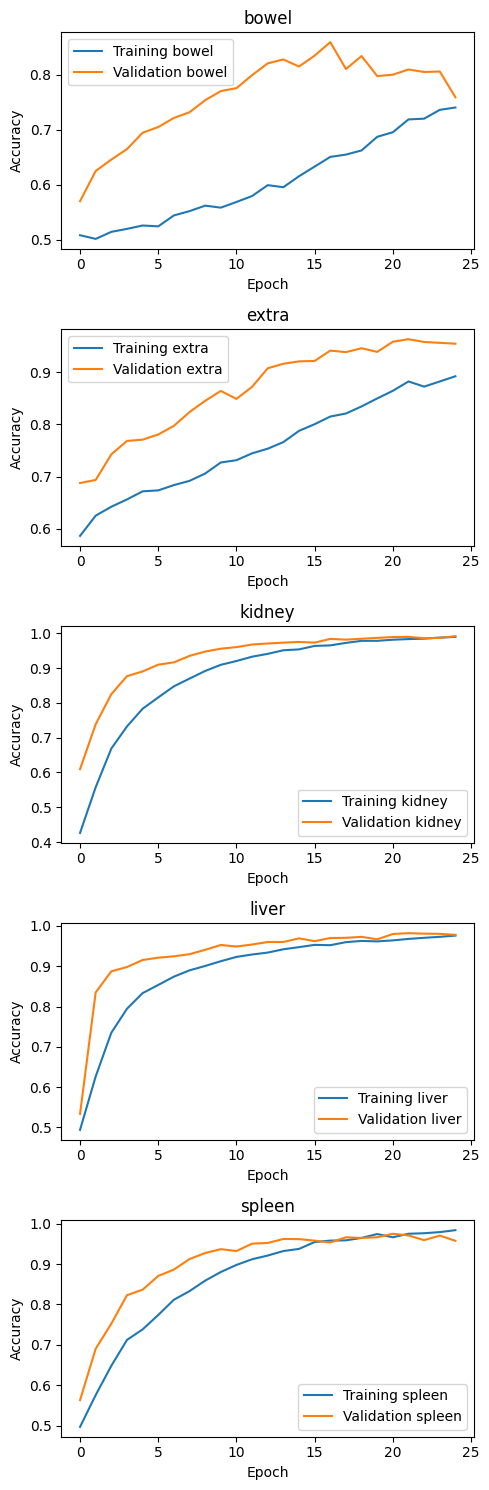

In [26]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

Validation loss vs training loss

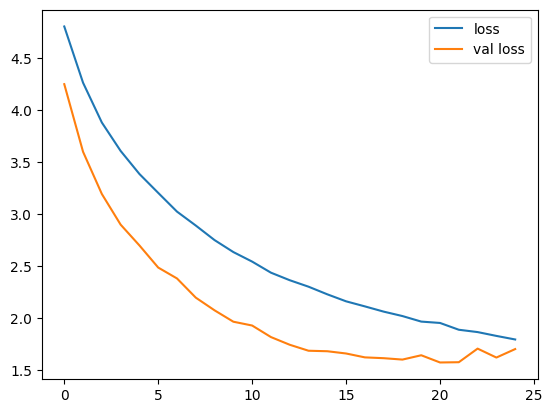

In [27]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [28]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 1.571
>>>> BEST Acc   : 0.941
>>>> BEST Epoch : 20

ORGAN Acc:
  >>>> Bowel           : 0.800
  >>>> Extravasation   : 0.959
  >>>> Liver           : 0.980
  >>>> Kidney          : 0.989
  >>>> Spleen          : 0.975


In [29]:
# Save the model
model.save("rsna-atd.keras")
model.save_weights("rsna-atd.weights.h5")